In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
from keras.applications import resnet50
from keras.layers import Lambda 
from keras.models import Input


input_tensor = Input((224, 224, 3))
x = input_tensor
x = Lambda(resnet50.preprocess_input)(x)

conv_base = resnet50.ResNet50(weights='imagenet',
                    include_top=False,
                    input_tensor=x)

In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator()
#datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 2048))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 12500 images belonging to 1 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (20000, 1 * 1 * 2048))
validation_features = np.reshape(validation_features, (5000, 1 * 1 * 2048))
test_features = np.reshape(test_features, (12500, 1 * 1 * 2048))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_dim=1 * 1 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [7]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=120,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 1s 38us/step - loss: 0.1360 - acc: 0.9525 - val_loss: 0.0469 - val_acc: 0.9842
Epoch 2/30
20000/20000 [==============================] - 1s 28us/step - loss: 0.0456 - acc: 0.9843 - val_loss: 0.0392 - val_acc: 0.9852
Epoch 3/30
20000/20000 [==============================] - 1s 30us/step - loss: 0.0368 - acc: 0.9871 - val_loss: 0.0370 - val_acc: 0.9868
Epoch 4/30
20000/20000 [==============================] - 1s 30us/step - loss: 0.0316 - acc: 0.9887 - val_loss: 0.0366 - val_acc: 0.9872
Epoch 5/30
20000/20000 [==============================] - 1s 30us/step - loss: 0.0294 - acc: 0.9894 - val_loss: 0.0367 - val_acc: 0.9878
Epoch 6/30
20000/20000 [==============================] - 1s 30us/step - loss: 0.0276 - acc: 0.9903 - val_loss: 0.0385 - val_acc: 0.9868
Epoch 7/30
20000/20000 [==============================] - 1s 30us/step - loss: 0.0271 - acc: 0.9904 - val_loss: 0.0363 - val_acc:

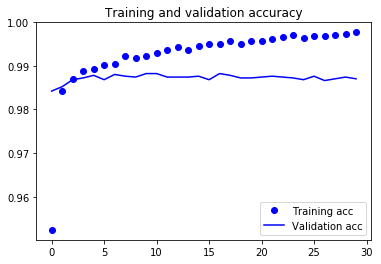

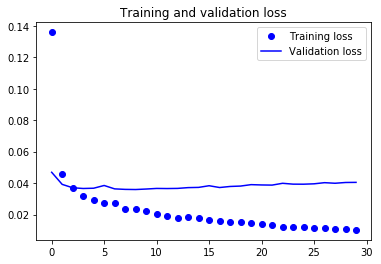

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
from keras.preprocessing import image
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import backend as K

x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=predictions)

In [11]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216


In [12]:
for layer in conv_base.layers:
    layer.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      #rescale=1./255
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
#test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/60
 - 194s - loss: 0.2268 - acc: 0.9119 - val_loss: 0.0656 - val_acc: 0.9762
Epoch 2/60
 - 185s - loss: 0.0941 - acc: 0.9659 - val_loss: 0.0530 - val_acc: 0.9804
Epoch 3/60
 - 188s - loss: 0.0778 - acc: 0.9713 - val_loss: 0.0699 - val_acc: 0.9768
Epoch 4/60
 - 185s - loss: 0.0734 - acc: 0.9711 - val_loss: 0.0627 - val_acc: 0.9778
Epoch 5/60
 - 184s - loss: 0.0684 - acc: 0.9725 - val_loss: 0.0492 - val_acc: 0.9832
Epoch 6/60
 - 185s - loss: 0.0674 - acc: 0.9731 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 7/60
 - 185s - loss: 0.0660 - acc: 0.9748 - val_loss: 0.0547 - val_acc: 0.9826
Epoch 8/60
 - 185s - loss: 0.0644 - acc: 0.9754 - val_loss: 0.0665 - val_acc: 0.9796
Epoch 9/60
 - 185s - loss: 0.0640 - acc: 0.9745 - val_loss: 0.0563 - val_acc: 0.9818
Epoch 10/60
 - 184s - loss: 0.0637 - acc: 0.9755 - val_loss: 0.0553 - val_acc: 0.9826
Epoch 11/60
 - 185s - loss: 0.0612 - acc: 0.9753 - val_loss: 0.0644 - val_acc: 0.9814
Epoch 12/60
 - 185s - loss: 0.0615 - acc: 0.9773 - val_loss: 0.

In [15]:
model.save('ResNet50_feature_extraction.h5')

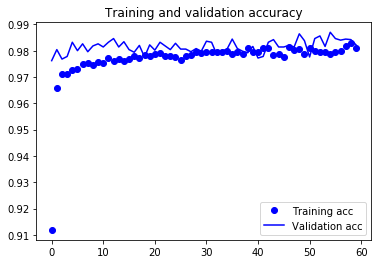

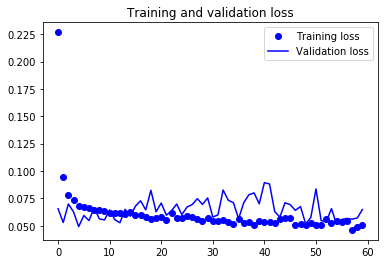

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (

In [18]:
for layer in model.layers[:168]:
    layer.trainable = False
for layer in model.layers[168:]:
    layer.trainable = True

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=5)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[early_stopping])

Epoch 1/100
200/200 [==============================] - 197s 987ms/step - loss: 0.0401 - acc: 0.9850 - val_loss: 0.0615 - val_acc: 0.9834
Epoch 2/100
200/200 [==============================] - 186s 932ms/step - loss: 0.0364 - acc: 0.9856 - val_loss: 0.0730 - val_acc: 0.9816
Epoch 3/100
200/200 [==============================] - 187s 937ms/step - loss: 0.0365 - acc: 0.9862 - val_loss: 0.0552 - val_acc: 0.9862
Epoch 4/100
200/200 [==============================] - 187s 934ms/step - loss: 0.0352 - acc: 0.9876 - val_loss: 0.0586 - val_acc: 0.9856
Epoch 5/100
200/200 [==============================] - 187s 936ms/step - loss: 0.0353 - acc: 0.9872 - val_loss: 0.0613 - val_acc: 0.9840
Epoch 6/100
200/200 [==============================] - 188s 941ms/step - loss: 0.0332 - acc: 0.9883 - val_loss: 0.0548 - val_acc: 0.9854
Epoch 7/100
200/200 [==============================] - 188s 938ms/step - loss: 0.0310 - acc: 0.9890 - val_loss: 0.0531 - val_acc: 0.9866
Epoch 8/100
200/200 [====================

In [21]:
model.save('ResNet50_Finetuning.h5')

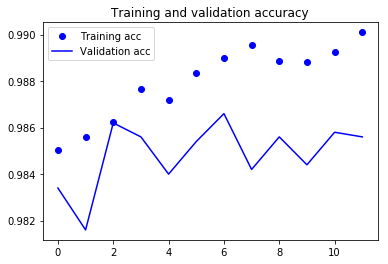

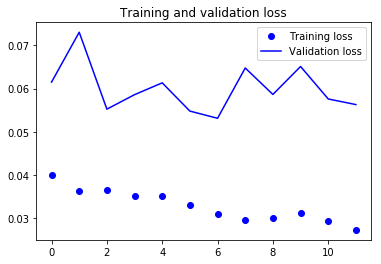

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode=None,
        shuffle=False)

id_batch = test_generator.filenames
print(id_batch[:10])

Found 12500 images belonging to 1 classes.
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']


In [25]:
y_pred = model.predict_generator(generator=test_generator,
                                 steps = 125,
                                 workers=1)

In [26]:
y_pred = y_pred.clip(min=0.005, max=0.995)
y_pred = y_pred.reshape(12500,)

In [27]:
from tqdm import tqdm

with open('ResNet50_Fintuning.csv','w') as f:
    f.write('id,label\n')
    
with open('ResNet50_Fintuning.csv','a') as f:
    i = 0
    for img_label in tqdm(y_pred):
        img_name = id_batch[i]
        img_id = int(img_name[img_name.rfind('/')+1:img_name.rfind('.')])
        f.write('{},{}\n'.format(img_id,img_label))
        i+=1

100%|██████████| 12500/12500 [00:00<00:00, 480623.37it/s]
